In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.style.use("seaborn-v0_8-whitegrid")

# 한글 폰트 경로 설정 (예시: NGULIM)
font_path = r"C:\Windows\Fonts\NGULIM.TTF"
font_prop = fm.FontProperties(fname=font_path)

# 폰트 설정
plt.rc('font', family=font_prop.get_name())

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# 데이터 전처리 및 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CIFAR10(root='../data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


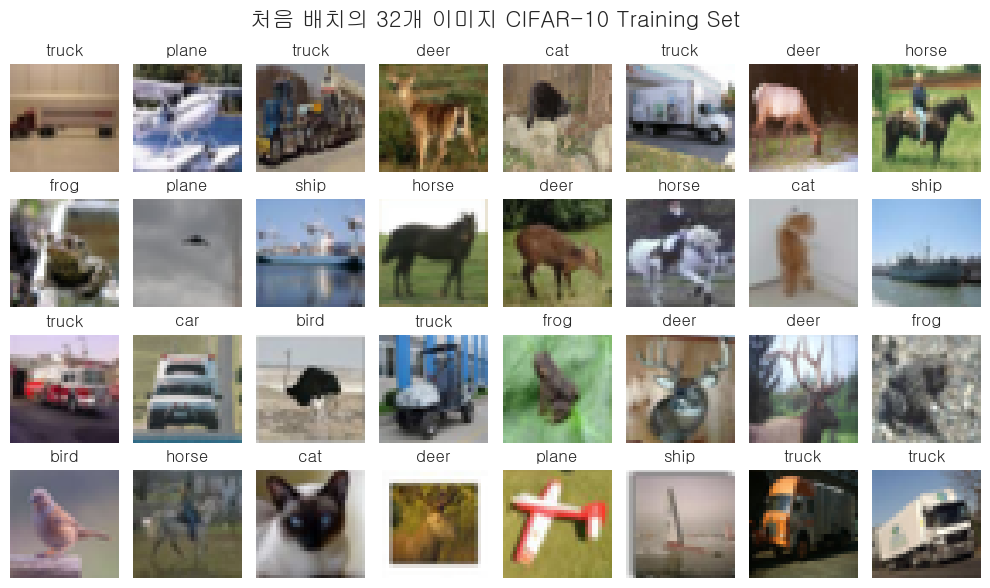

In [3]:
# CIFAR-10 클래스 이름 정의
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 첫 번째 배치의 데이터 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 시각화를 위한 함수 정의
def imshow(ax, img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

# 첫 번째 배치의 32개 이미지 시각화
fig, axes = plt.subplots(4, 8, figsize=(10, 6))
fig.suptitle('처음 배치의 32개 이미지 CIFAR-10 Training Set', fontsize=16)
axes = axes.ravel()

for idx in range(32):
    ax = axes[idx]
    imshow(ax, images[idx])
    ax.set_title(classes[labels[idx].item()])

plt.tight_layout()
plt.show()

### CNN 모델 구현 및 학습

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm

# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 첫 번째 컨볼루션 층: 입력 채널 3개 (RGB 이미지), 출력 채널 16개, 커널 크기 3x3, 패딩 1
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 최대 풀링 층: 커널 크기 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # 두 번째 컨볼루션 층: 입력 채널 16개, 출력 채널 32개, 커널 크기 3x3, 패딩 1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 첫 번째 완전 연결 층: 입력 크기 32 * 8 * 8, 출력 크기 128
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        # 두 번째 완전 연결 층: 입력 크기 128, 출력 크기 10 (분류 클래스 수)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 첫 번째 컨볼루션 층을 적용하고, ReLU 활성화 함수 적용 후 최대 풀링
        x = self.pool(F.relu(self.conv1(x)))
        # 두 번째 컨볼루션 층을 적용하고, ReLU 활성화 함수 적용 후 최대 풀링
        x = self.pool(F.relu(self.conv2(x)))
        # 완전 연결 층에 입력하기 위해 텐서를 평탄화 (배치 크기를 제외한 모든 차원을 일렬로 나열)
        x = x.view(-1, 32 * 8 * 8)
        # 첫 번째 완전 연결 층을 적용하고, ReLU 활성화 함수 적용
        x = F.relu(self.fc1(x))
        # 두 번째 완전 연결 층을 적용 (출력 클래스 수로 매핑)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SimpleCNN 모델 객체 생성
model = SimpleCNN().to(device)

# 손실 함수 정의: 다중 클래스 분류를 위한 교차 엔트로피 손실
criterion = nn.CrossEntropyLoss()
# 최적화 방법 설정: AdamW 옵티마이저 사용, 학습률 0.001, 가중치 감소 (정규화) 0.01
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
# 학습률 스케줄러 설정: 10 에포크마다 학습률을 0.1 배로 감소
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 학습 및 검증 데이터 저장 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# 학습 에포크 수 설정
epochs = 10

# 모델 학습
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if i % 100 == 99:
        print(f"[{epoch + 1}] loss: {train_loss / 100:.3f}, accuracy: {train_accuracy / 100:.3f}")
        running_loss = 0.0

    scheduler.step()

print('학습 완료')

학습 완료


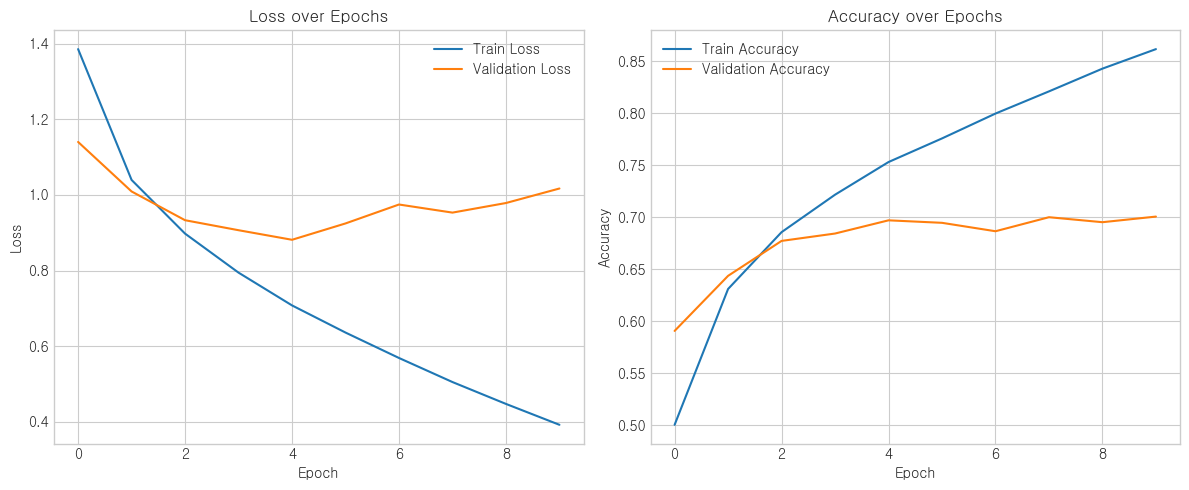

In [5]:
# 학습 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()